In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df = pd.read_csv('../datasets/famcs_students.csv')

target_col = 'interest'

print("Распределение классов:")
print(df[target_col].value_counts())

df = df[df['height'] > 140].copy()

features_num = ['score', 'height', 'age']
features_cat = ['sex', 'work_experience', 'os']

df['target'] = df[target_col].apply(lambda x: 1 if 'Программирование' in str(x) else 0)

df['sex_code'] = df['sex'].map({'М': 1, 'Ж': 0})

os_map = {k: v for v, k in enumerate(df['os'].unique())}
df['os_code'] = df['os'].map(os_map)

exp_map = {
    'Не работаю': 0,
    'Меньше года': 1,
    '1-2 года': 2,
    'более 2 лет': 3
}
df['exp_code'] = df['work_experience'].map(exp_map).fillna(0) # fillna на всякий случай

feature_cols = ['score', 'height', 'age', 'sex_code', 'os_code', 'exp_code']

X_raw = df[feature_cols].values
y = df['target'].values

print(f"\nРазмер выборки: {X_raw.shape}")

print(df[feature_cols])

Распределение классов:
interest
Программирование    103
Математика           24
Name: count, dtype: int64

Размер выборки: (126, 6)
     score  height   age  sex_code  os_code  exp_code
0     9.20   192.0  20.0         1        0         1
1     8.80   169.0  20.0         0        0         2
2     8.80   190.0  19.0         0        0         1
3     8.80   158.0  20.0         0        0         2
4     9.00   187.0  20.0         1        1         0
..     ...     ...   ...       ...      ...       ...
122   6.29   185.0  20.0         1        1         0
123   6.00   169.0  22.0         0        1         0
124   7.00   183.0  21.0         1        1         0
125   7.00   187.0  20.0         1        1         2
126   6.00   186.0  20.0         1        1         2

[126 rows x 6 columns]


In [43]:
# Нормализация данных (Z-score), критически важно для k-NN и LogReg
mean = X_raw.mean(axis=0)
std = X_raw.std(axis=0) + 1e-8
X_scaled = (X_raw - mean) / std

np.random.seed(42)

indices = np.random.permutation(len(X_scaled))
n = len(indices)

train_idx = indices[:int(0.7 * n)]
val_idx = indices[int(0.7 * n):int(0.85 * n)]
test_idx = indices[int(0.85 * n):]

X_train, y_train = X_scaled[train_idx], y[train_idx]
X_val, y_val = X_scaled[val_idx], y[val_idx]
X_test, y_test = X_scaled[test_idx], y[test_idx]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (88, 6), Val: (19, 6), Test: (19, 6)


In [44]:
def get_metrics(y_true, y_pred, y_prob=None):
    # TP, TN, FP, FN
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'matrix': [[tn, fp], [fn, tp]]
    }

def print_metrics(metrics, name="Model"):
    print(f"--- {name} ---")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-score:  {metrics['f1']:.4f}")
    print(f"Confusion Matrix:\n{np.array(metrics['matrix'])}")
    print("")

In [45]:
# Наиболее частый класс в Train
unique, counts = np.unique(y_train, return_counts=True)
majority_class = unique[np.argmax(counts)]

y_pred_trivial = np.full(shape=y_test.shape, fill_value=majority_class)

metrics_trivial = get_metrics(y_test, y_pred_trivial)
print_metrics(metrics_trivial, "Trivial Model")

--- Trivial Model ---
Accuracy:  0.8947
Precision: 0.8947
Recall:    1.0000
F1-score:  0.9444
Confusion Matrix:
[[ 0  2]
 [ 0 17]]



In [46]:
class MyGaussianNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.params = {}

        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {
                'mean': X_c.mean(axis=0),
                'var': X_c.var(axis=0) + 1e-9, # сглаживание
                'prior': len(X_c) / len(X)
            }
            

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.params[c]['prior'])
                mean = self.params[c]['mean']
                var = self.params[c]['var']

                # Логарифм функции правдоподобия Гаусса
                numerator = -((x - mean) ** 2) / (2 * var)
                denominator = -0.5 * np.log(2 * np.pi * var)
                likelihood = np.sum(numerator + denominator)

                posteriors.append(prior + likelihood)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)

nb_model = MyGaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

metrics_nb = get_metrics(y_test, y_pred_nb)
print_metrics(metrics_nb, "Naive Bayes")

--- Naive Bayes ---
Accuracy:  0.6842
Precision: 0.8667
Recall:    0.7647
F1-score:  0.8125
Confusion Matrix:
[[ 0  2]
 [ 4 13]]



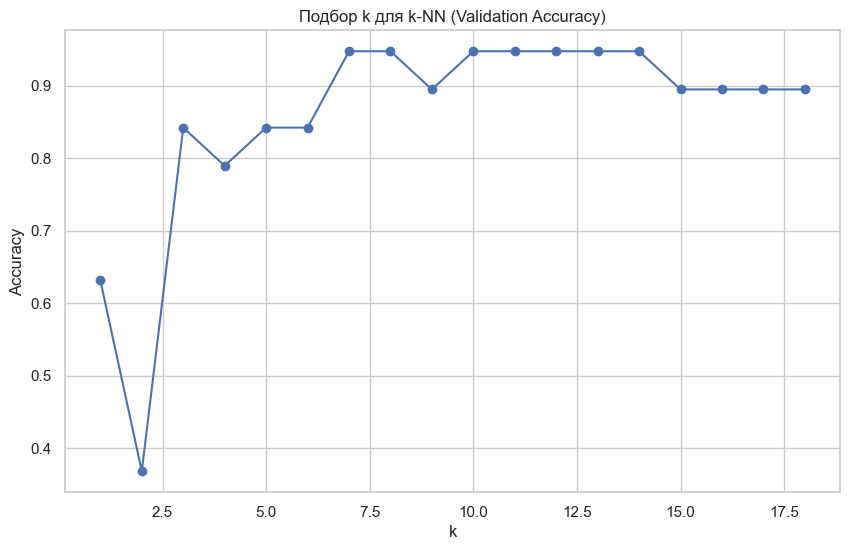

Лучший k: 7 (Accuracy: 0.9474)
--- k-NN (k=7) ---
Accuracy:  0.8947
Precision: 0.8947
Recall:    1.0000
F1-score:  0.9444
Confusion Matrix:
[[ 0  2]
 [ 0 17]]



In [47]:
class MyKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            y_pred.append(unique[np.argmax(counts)])
        return np.array(y_pred)

k_values = range(1, 19)
best_k = 1
best_acc = 0

acc_history = []

for k in k_values:
    knn = MyKNN(k=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    acc = np.mean(preds == y_val)
    acc_history.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_k = k

plt.plot(k_values, acc_history, marker='o')
plt.title("Подбор k для k-NN (Validation Accuracy)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

print(f"Лучший k: {best_k} (Accuracy: {best_acc:.4f})")

best_knn = MyKNN(k=best_k)
best_knn.fit(X_train, y_train)
y_pred_knn = best_knn.predict(X_test)

metrics_knn = get_metrics(y_test, y_pred_knn)
print_metrics(metrics_knn, f"k-NN (k={best_k})")

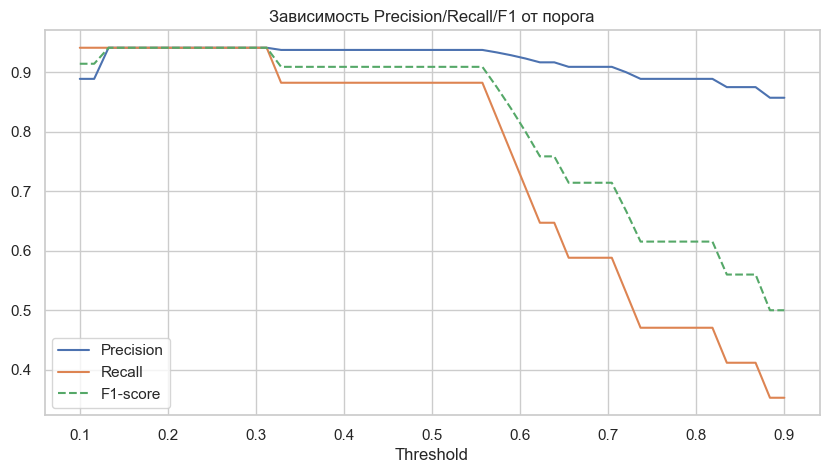

Оптимальный порог: 0.13 (Max F1: 0.9412)
--- Logistic Regression (thr=0.13) ---
Accuracy:  0.8947
Precision: 0.8947
Recall:    1.0000
F1-score:  0.9444
Confusion Matrix:
[[ 0  2]
 [ 0 17]]



In [48]:
class MyLogisticRegression:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.epochs):
            linear_model = X @ self.w + self.b
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict_proba(self, X):
        linear_model = X @ self.w + self.b
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

log_reg = MyLogisticRegression(lr=0.1, epochs=3000)
log_reg.fit(X_train, y_train)

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

probs_val = log_reg.predict_proba(X_val)

for t in thresholds:
    preds = (probs_val >= t).astype(int)
    m = get_metrics(y_val, preds)
    precisions.append(m['precision'])
    recalls.append(m['recall'])
    f1_scores.append(m['f1'])

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score', linestyle='--')
plt.title("Зависимость Precision/Recall/F1 от порога")
plt.xlabel("Threshold")
plt.legend()
plt.show()

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"Оптимальный порог: {best_threshold:.2f} (Max F1: {f1_scores[best_threshold_idx]:.4f})")

y_pred_logreg = log_reg.predict(X_test, threshold=best_threshold)
metrics_logreg = get_metrics(y_test, y_pred_logreg)
print_metrics(metrics_logreg, f"Logistic Regression (thr={best_threshold:.2f})")

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve


y_prob_logreg = log_reg.predict_proba(X_test)

auc_logreg = roc_auc_score(y_test, y_prob_logreg)
auc_nb = roc_auc_score(y_test, y_pred_nb)
auc_knn = roc_auc_score(y_test, y_pred_knn)
auc_trivial = 0.5

print(f"ROC-AUC Logistic Regression: {auc_logreg:.4f}")
print(f"ROC-AUC Naive Bayes:         {auc_nb:.4f}")
print(f"ROC-AUC k-NN:                {auc_knn:.4f}")

results = pd.DataFrame({
    'Model': ['Trivial', 'Naive Bayes', f'k-NN (k={best_k})', 'LogReg'],
    'Accuracy': [metrics_trivial['accuracy'], metrics_nb['accuracy'], metrics_knn['accuracy'], metrics_logreg['accuracy']],
    'Precision': [metrics_trivial['precision'], metrics_nb['precision'], metrics_knn['precision'], metrics_logreg['precision']],
    'Recall': [metrics_trivial['recall'], metrics_nb['recall'], metrics_knn['recall'], metrics_logreg['recall']],
    'F1-score': [metrics_trivial['f1'], metrics_nb['f1'], metrics_knn['f1'], metrics_logreg['f1']],
    'ROC-AUC': [auc_trivial, auc_nb, auc_knn, auc_logreg]
})

print("\nИТОГОВАЯ ТАБЛИЦА:")
results.round(4)

ROC-AUC Logistic Regression: 0.2059
ROC-AUC Naive Bayes:         0.3824
ROC-AUC k-NN:                0.5000

ИТОГОВАЯ ТАБЛИЦА:


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,Trivial,0.8947,0.8947,1.0000,0.9444,0.5000
1,Naive Bayes,0.6842,0.8667,0.7647,0.8125,0.3824
2,k-NN (k=7),0.8947,0.8947,1.0000,0.9444,0.5000
3,LogReg,0.8947,0.8947,1.0000,0.9444,0.2059
